In [2]:
#필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import torch
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import torch.nn as nn
import torch.optim as optim

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        size=(224, 224),
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\tkdwl\AppData\Local\Temp\ipykernel_230824\2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


총 훈련 이미지 개수:  200


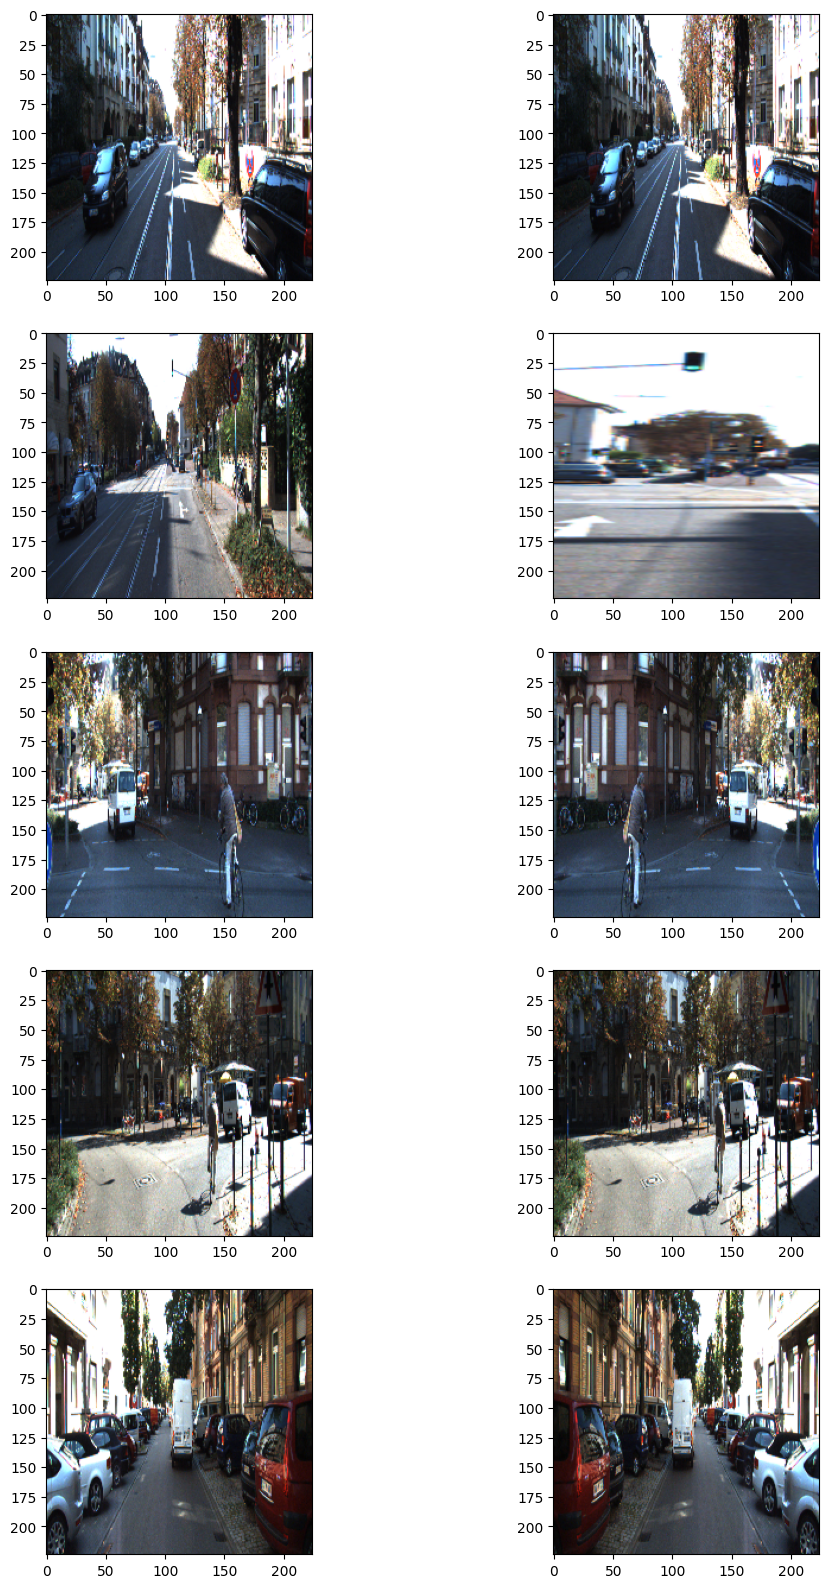

In [4]:
data_dir = "C:\\Users\\tkdwl\\AIFFEL_quest_rs\\GoingDeeper\\GD07\\datas\\training"

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(data_dir, "image_2", "*.png"))
print("총 훈련 이미지 개수: ", len(input_images))
# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [5]:
from torch.utils.data import Dataset

class KittiDataset(Dataset):
    '''
    KittiDataset은 PyTorch의 Dataset을 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Dataset을 커스텀하여 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Dataset이 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해 kitti dataset의 경로에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Dataset의 length로서 전체 dataset 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path)
        _output = imread(output_path)

        # 특정 라벨을 이진 마스크로 변환
        _output = (_output == 7).astype(np.uint8) * 1

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0  # Normalize
            _output = augmented["mask"]

        # 📌 target 차원 확장 (H, W) → (1, H, W)
        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),  # (H, W, C) → (C, H, W)
            torch.tensor(_output, dtype=torch.float32)  # (1, H, W) 형식 유지
        )

    def shuffle_data(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 데이터를 random shuffle합니다.
        if self.is_train:
            np.random.shuffle(self.data)

In [6]:
from torch.utils.data import DataLoader

# Augmentation 설정
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_dataset = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

test_dataset = KittiDataset(
    data_dir,
    augmentation=test_preproc,
    is_train=False
)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

C:\Users\tkdwl\AppData\Local\Temp\ipykernel_230824\2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):  # 이름은 그대로 두고 내부를 UNet++로 변경
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        nb_filter = [64, 128, 256, 512, 1024]

        # Encoder (X_{i,0})
        self.conv0_0 = self.double_conv(input_channels, nb_filter[0])
        self.conv1_0 = self.double_conv(nb_filter[0], nb_filter[1])
        self.conv2_0 = self.double_conv(nb_filter[1], nb_filter[2])
        self.conv3_0 = self.double_conv(nb_filter[2], nb_filter[3])
        self.conv4_0 = self.double_conv(nb_filter[3], nb_filter[4])

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)

        # Decoder: Nested skip connections (UNet++)
        # X_{i,1}
        self.conv0_1 = self.double_conv(nb_filter[0] + nb_filter[1], nb_filter[0])
        self.conv1_1 = self.double_conv(nb_filter[1] + nb_filter[2], nb_filter[1])
        self.conv2_1 = self.double_conv(nb_filter[2] + nb_filter[3], nb_filter[2])
        self.conv3_1 = self.double_conv(nb_filter[3] + nb_filter[4], nb_filter[3])

        # X_{i,2}
        self.conv0_2 = self.double_conv(nb_filter[0] + nb_filter[1] * 2, nb_filter[0])
        self.conv1_2 = self.double_conv(nb_filter[1] + nb_filter[2] * 2, nb_filter[1])
        self.conv2_2 = self.double_conv(nb_filter[2] + nb_filter[3] * 2, nb_filter[2])

        # X_{i,3}
        self.conv0_3 = self.double_conv(nb_filter[0] + nb_filter[1] * 3, nb_filter[0])
        self.conv1_3 = self.double_conv(nb_filter[1] + nb_filter[2] * 3, nb_filter[1])

        # X_{0,4}
        self.conv0_4 = self.double_conv(nb_filter[0] + nb_filter[1] * 4, nb_filter[0])

        # Output layer (입출력 유지)
        self.final = nn.Conv2d(nb_filter[0], output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """2개의 Conv Layer로 이루어진 블록"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def _upsample(self, x, target):
        """bilinear 업샘플 (크기만 맞추고 채널 수는 그대로 유지)"""
        return F.interpolate(x, size=target.shape[2:], mode="bilinear", align_corners=True)

    def forward(self, x):
        # Encoder: X_{i,0}
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        x4_0 = self.dropout(x4_0)

        # X_{i,1}
        x0_1 = self.conv0_1(torch.cat([
            x0_0,
            self._upsample(x1_0, x0_0)
        ], dim=1))

        x1_1 = self.conv1_1(torch.cat([
            x1_0,
            self._upsample(x2_0, x1_0)
        ], dim=1))

        x2_1 = self.conv2_1(torch.cat([
            x2_0,
            self._upsample(x3_0, x2_0)
        ], dim=1))

        x3_1 = self.conv3_1(torch.cat([
            x3_0,
            self._upsample(x4_0, x3_0)
        ], dim=1))

        # X_{i,2}
        x0_2 = self.conv0_2(torch.cat([
            x0_0,
            self._upsample(x1_0, x0_0),
            self._upsample(x1_1, x0_0),
        ], dim=1))

        x1_2 = self.conv1_2(torch.cat([
            x1_0,
            self._upsample(x2_0, x1_0),
            self._upsample(x2_1, x1_0),
        ], dim=1))

        x2_2 = self.conv2_2(torch.cat([
            x2_0,
            self._upsample(x3_0, x2_0),
            self._upsample(x3_1, x2_0),
        ], dim=1))

        # X_{i,3}
        x0_3 = self.conv0_3(torch.cat([
            x0_0,
            self._upsample(x1_0, x0_0),
            self._upsample(x1_1, x0_0),
            self._upsample(x1_2, x0_0),
        ], dim=1))

        x1_3 = self.conv1_3(torch.cat([
            x1_0,
            self._upsample(x2_0, x1_0),
            self._upsample(x2_1, x1_0),
            self._upsample(x2_2, x1_0),
        ], dim=1))

        # X_{0,4} (최종 출력용 노드)
        x0_4 = self.conv0_4(torch.cat([
            x0_0,
            self._upsample(x1_0, x0_0),
            self._upsample(x1_1, x0_0),
            self._upsample(x1_2, x0_0),
            self._upsample(x1_3, x0_0),
        ], dim=1))

        out = torch.sigmoid(self.final(x0_4))
        return out


In [8]:
# 모델 저장 경로
model_path = "C:\\Users\\tkdwl\\AIFFEL_quest_rs\\GoingDeeper\\GD07\\datas\\seg_model_unet.pth"

# 모델 생성
model = UNet(input_channels=3, output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# 모델 저장
torch.save(model.state_dict(), model_path)

Epoch 1/100, Loss: 0.6693035635081205
Epoch 2/100, Loss: 0.555884911255403
Epoch 3/100, Loss: 0.4904984019019387
Epoch 4/100, Loss: 0.37987093221057544
Epoch 5/100, Loss: 0.3744173916903409
Epoch 6/100, Loss: 0.33056841926141217
Epoch 7/100, Loss: 0.2812381684780121
Epoch 8/100, Loss: 0.2672941467978738
Epoch 9/100, Loss: 0.23750939287922598
Epoch 10/100, Loss: 0.23363654044541446
Epoch 11/100, Loss: 0.22336399690671402
Epoch 12/100, Loss: 0.21566777337681164
Epoch 13/100, Loss: 0.1866828060962937
Epoch 14/100, Loss: 0.19205216115171259
Epoch 15/100, Loss: 0.22402085770260205
Epoch 16/100, Loss: 0.1984474022280086
Epoch 17/100, Loss: 0.1816728033802726
Epoch 18/100, Loss: 0.1800811399113048
Epoch 19/100, Loss: 0.1794743307612159
Epoch 20/100, Loss: 0.19565271112051877
Epoch 21/100, Loss: 0.1869170977310701
Epoch 22/100, Loss: 0.17775572904131628
Epoch 23/100, Loss: 0.1643242673440413
Epoch 24/100, Loss: 0.15823928063566034
Epoch 25/100, Loss: 0.17782621492039075
Epoch 26/100, Loss: 0.1

In [9]:
model = UNet(input_channels=3, output_channels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 평가 모드로 전환

UNet(
  (conv0_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv1_0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2_0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3_0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv4_0): Sequential(
    (0): Conv2d(512

In [10]:
import matplotlib.pyplot as plt

def get_output(model, preproc, image_path, output_path):
    # 원본 이미지 로드
    origin_img = imread(image_path)
    data = {"image": origin_img}

    # 전처리 적용
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 모델 추론 (inference)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 시그모이드 활성화 후 임계값(0.5) 적용하여 바이너리 마스크 생성
    output = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255   #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)

    # 배경과 결합하여 시각화 (Overlay)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, output, alpha=0.5)

    # 변환된 이미지 저장
    blended.save(output_path)

    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    # blended.show()
    return blended

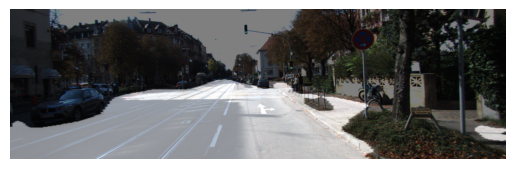

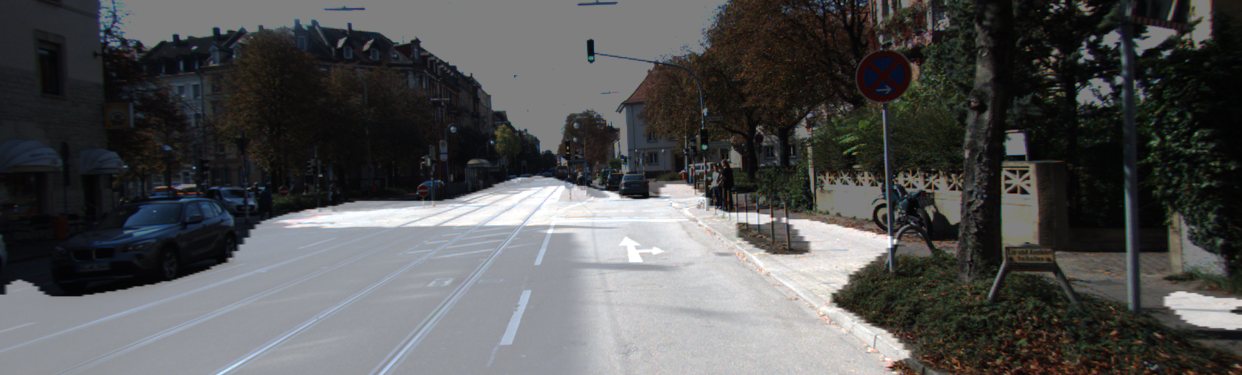

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
get_output(
     model,
     test_preproc,
     image_path=data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=data_dir + f'/result_{str(i).zfill(3)}.png'
 )

In [12]:
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print(f"IoU : {iou_score:.6f}")
    return iou_score

In [13]:
def get_output(model, preproc, image_path, output_path, label_path=None):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    prediction = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    background = Image.fromarray(origin_img).convert('RGBA')
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)

    blended.save(output_path)
    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)["image"]
        target = (label_processed == 7).astype(np.uint8) * 1

    return blended, np.array(prediction), target

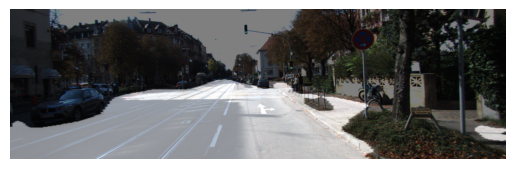

IoU : 0.859545


np.float64(0.859544731191728)

In [14]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model,
     test_preproc,
     image_path=data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=data_dir + f'/result_{str(i).zfill(3)}.png',
     label_path=data_dir + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)